The purpose of this notebook is to quantify the interannual variability in the tropical humidity distribution in the ERA5 data

In [7]:
from importlib import reload
import numpy as np
import os
import random
import pickle
import multiprocessing
import functools
import seaborn
import logging
import typhon
import cmocean
from pylab import cm
from os.path import join
from netCDF4 import Dataset
from tqdm import tqdm_notebook
from scipy.interpolate import interp1d
from scipy.signal import detrend
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import processing_tools as ptools
import analysis_tools as atools
from importlib import reload
from moisture_space import utils, plots
from moisture_space import moisture_space
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING)
plt.style.use(typhon.plots.styles.get('typhon'))   

# Config

In [2]:
years = [2014, 2015, 2016, 2017, 2018]        
time_period = ['0810', '0908']
variables_3D = ['TEMP', 'PRES', 'QV', 'QI', 'QC', 'RH', 'ICQI', 'CFI', 'ICQC', 'CFL', 'W']
variables_2D = ['IWV', 'H_tropo']
datapath = '/mnt/lustre02/work/mh1126/m300773/DYAMOND/ERA5'
filenames = '{}-{}_{}_sample_{}_{}-{}.nc'
num_profiles = int(1 * 1e7)
perc_values = np.arange(1, 100.5, 1.0)
num_percs = len(perc_values)
iwv_bin_bnds = np.arange(0, 101, 1)
bins = range(len(iwv_bin_bnds) - 1) 
exp = 0
h = np.arange(100, 17900, 400) # height vector to interpolate on
height = {}
num_levels = {}
filename = filenames.format('ERA5', '31.0km', variables_3D[0], num_profiles, time_period[0], time_period[1])
filename = join(datapath, str(years[0]), 'random_samples', filename)

with(Dataset(filename)) as ds:
    height = ds.variables['height'][:].filled(np.nan)
num_levels = len(height)        

# Read data

In [3]:
ms_perc = {}
ms_bins = {}
percentiles = {}
for year in years:
    path = join(datapath, str(year), 'random_samples')
    file_perc = f'ERA5-31.0km_{time_period[0]}-{time_period[1]}_perc_means_{num_profiles}_1exp.pkl'
    file_bin = f'ERA5-31.0km_{time_period[0]}-{time_period[1]}_bin_means_{num_profiles}_1exp.pkl'
    with open(join(path, file_perc), 'rb' ) as infile:
        perc = pickle.load(infile)
    with open(join(path, file_bin), 'rb' ) as infile:
        binned = pickle.load(infile)

    ms_perc[year] = {}
    ms_bins[year] = {}
    for var in variables_3D:
        stats_perc = moisture_space.ProfileStats.from_dict(perc, var)
        ms_perc[year][var] = moisture_space.PercMoistureSpace(year, stats_perc, perc_values, height).interpolate(h)
        stats_bin = moisture_space.ProfileStats.from_dict(binned, var)
        ms_bins[year][var] = moisture_space.BinMoistureSpace(year, stats_bin, perc_values, height, binned['count']).interpolate(h)
        ms_bins[year][var].remove_empty_bins(number_threshold=300)
    for var in variables_2D:
        stats_perc = moisture_space.ProfileStats.from_dict(perc, var)
        ms_perc[year][var] = moisture_space.PercMoistureSpace(year, stats_perc, perc_values, None)   
        stats_bin = moisture_space.ProfileStats.from_dict(binned, var)
        ms_bins[year][var] = moisture_space.BinMoistureSpace(year, stats_bin, perc_values, None, binned['count'])
        ms_bins[year][var].remove_empty_bins(number_threshold=300)

# Create collection of moisture spaces from different years

In [4]:
reload(moisture_space)
ms_perc_series = {}
for var in variables_3D:
    perc_space_list = [ms_perc[year][var] for year in years]
    ms_perc_series[var] = moisture_space.MoistureSpaceSeries(perc_space_list)

# Mean profiles

In [5]:
# Save mean profiles to .pkl file
mean_profiles = {}
mean_profiles['height'] = h
for n, year in enumerate(years):
    mean_profiles[year] = {}
    for var in variables_3D:
        mean_profiles[year][var] = ms_perc[year][var].mean_profile()

with open(os.path.join(datapath, f'ERA5_tropical_mean_profiles_{years[0]}-{years[-1]}.pkl'), 'wb') as outfile:
    pickle.dump(mean_profiles, outfile)
        

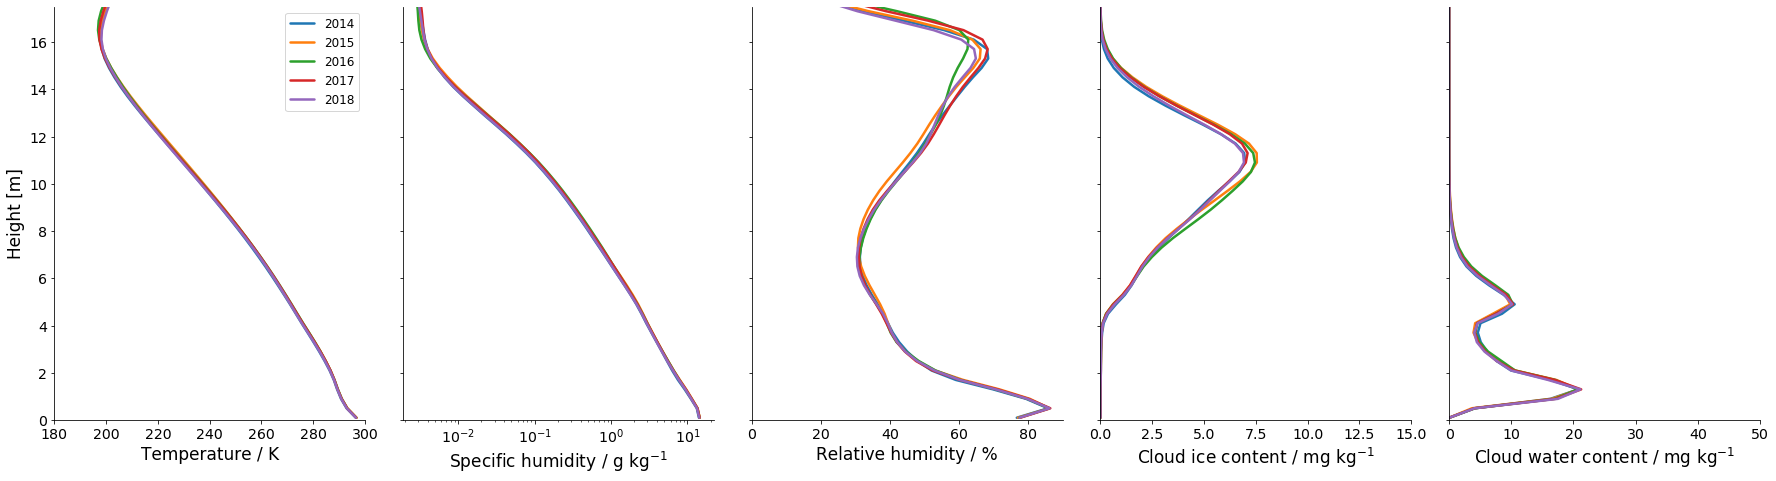

In [8]:
reload(plots)
plt.rcParams.update({'font.size': 15})
plot_vars = ['TEMP', 'QV', 'RH', 'QI', 'QC']
num_vars = len(plot_vars)
bin_start= 0
bin_end = 100
plt.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(1, num_vars, figsize=(5 * num_vars, 7), sharey=True)
for i, var in enumerate(plot_vars):
    for year in years:
        if var == 'QV':
            ax[i].semilogx(ms_perc[year][var].mean_profile(bin_start, bin_end) * plots.scaling_factors(ms_perc[year][var].variable),
                           h * 1e-3, lw=2.5, label=year)
        else:
            ax[i].plot(ms_perc[year][var].mean_profile(bin_start, bin_end) * plots.scaling_factors(ms_perc[year][var].variable),\
                       h * 1e-3, lw=2.5, label=year)
        ax[i].set_xlabel(plots.axis_labels(ms_perc[year][var].variable))
        
        ax[i].set_ylim(0, 17.5)
        seaborn.despine(ax=ax[i])
ax[0].set_ylabel('Height [m]')
#ax[1].set_xlim(0, 20)
ax[0].set_xlim(180, 300)
ax[2].set_xlim(0, 90)
ax[3].set_xlim(0, 15)
ax[4].set_xlim(0, 50)
ax[0].legend(fontsize=12)
plt.tight_layout()

# IWV distribution

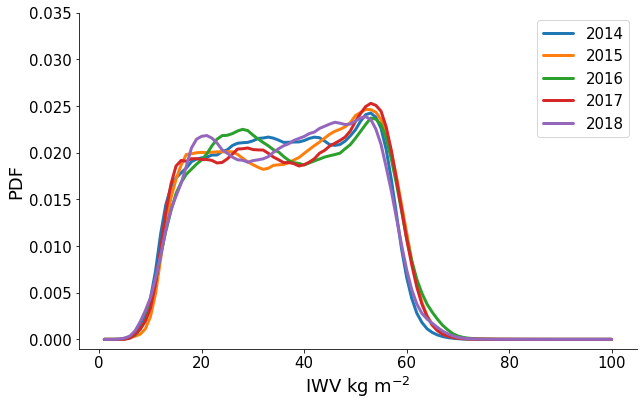

In [98]:
fig, ax = plt.subplots()
for year in years:
    iwv_pdf = ms_bins[year]['IWV'].profile_pdf / np.sum(ms_bins[year]['IWV'].profile_pdf)
    ax.plot(perc_values, iwv_pdf, lw=3, label=year)
ax.set_ylim(-0.001, 0.035)
ax.set_xlabel('IWV kg m$^{-2}$')
ax.set_ylabel('PDF')
ax.legend()

# Distribution of RH in moisture space

DEBUG:locator: <matplotlib.ticker.FixedLocator object at 0x2af2ac94bbe0>
DEBUG:Using fixed locator on colorbar
DEBUG:Setting pcolormesh
DEBUG:locator: <matplotlib.ticker.FixedLocator object at 0x2af2aca03978>
DEBUG:Using fixed locator on colorbar
DEBUG:Setting pcolormesh
DEBUG:locator: <matplotlib.ticker.FixedLocator object at 0x2af2acabdcf8>
DEBUG:Using fixed locator on colorbar
DEBUG:Setting pcolormesh
DEBUG:locator: <matplotlib.ticker.FixedLocator object at 0x2af2acfdd908>
DEBUG:Using fixed locator on colorbar
DEBUG:Setting pcolormesh
DEBUG:locator: <matplotlib.ticker.FixedLocator object at 0x2af2ad00bd30>
DEBUG:Using fixed locator on colorbar
DEBUG:Setting pcolormesh


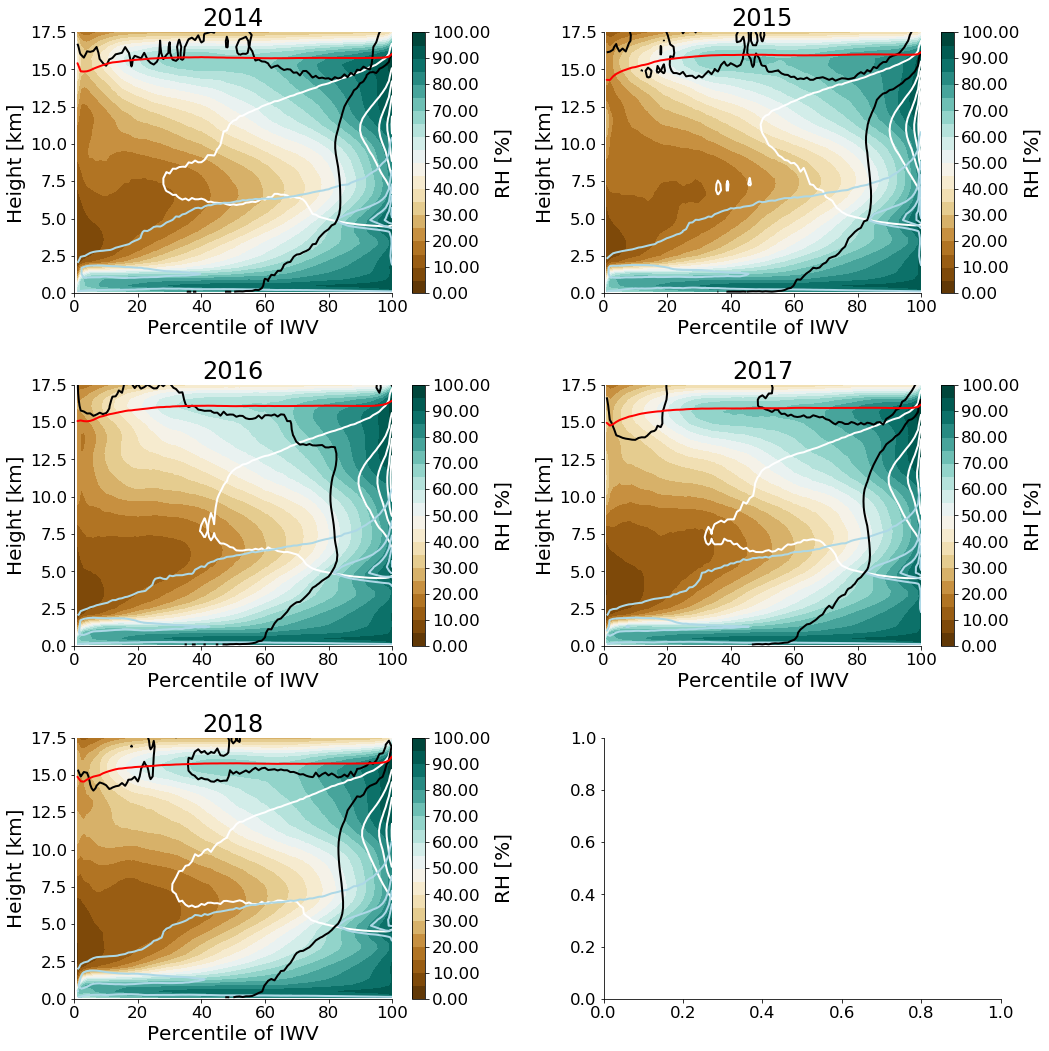

In [101]:
reload(plots)
fig, ax = plt.subplots(np.ceil(len(years) / 2).astype(int), 2, figsize=(15, 15))
tick_labels = np.arange(10, 81, 10)
ax = ax.ravel()

plt.rcParams.update({'font.size': 20})
x_lims = [0, 100]
y_lims = [0, 17.5]
x_label = 'Percentile of IWV'#axis_labels['IWV']
y_label = 'Height [km]'
contours = np.arange(0, 101, 5)
contours_ci = np.arange(1, 200, 20)
contours_cl = contours_ci

lower_layer_bnd = 100
upper_layer_bnd = 12500

for i, year in enumerate(years):
    plots.moisture_space_contourf(fig, ax[i], perc_values, h * 1e-3, (ms_perc[year]['RH'].mean.T) * 1e2, contours,\
                                  x_lims, y_lims, x_label, y_label, 'RH [%]',
                                  cm_orientation='vertical', cb_extend='neither', cb_ticks=np.arange(0, 110, 10),\
                                  cmap='BrBG', vmin=0, vmax=100)
        
    ci = plots.moisture_space_contour(fig, ax[i], perc_values, h * 1e-3, ms_perc[year]['QI'].mean.T * 1e6, contours_ci,\
                                  x_lims, y_lims, x_label, y_label, 'w')
    cl = plots.moisture_space_contour(fig, ax[i], perc_values, h * 1e-3, ms_perc[year]['QC'].mean.T * 1e6, contours_cl,\
                                   x_lims, y_lims, x_label, y_label, 'lightblue')
    cs = plots.moisture_space_contour(fig, ax[i], perc_values, h * 1e-3, ms_perc[year]['W'].mean.T,\
                             [0.0], x_lims, y_lims, x_label, y_label, 'k')
    #cs = plots.moisture_space_contour(fig, ax[i], perc_values, h * 1e-3, ms_perc[exp]['W'].mean.T,\
    #                         [0.0], x_lims, y_lims, x_label, y_label, 'k')
    plots.moisture_space_line(ax[i], perc_values, ms_perc[year]['H_tropo'].mean * 1e-3,\
                                  x_lims, y_lims, x_label, y_label, lw=2, label=year, color='r')
    ax[i].set_title(year)

plt.tight_layout()

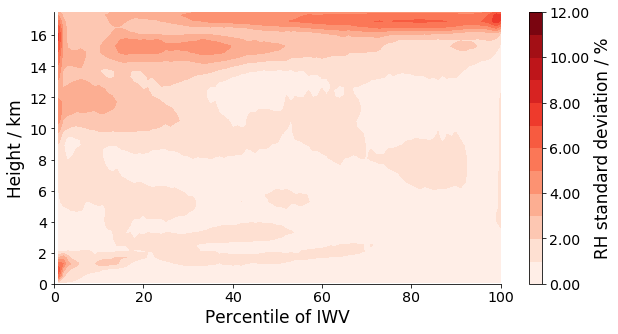

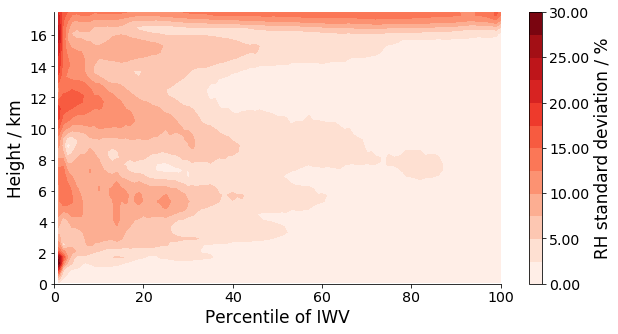

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
x_lims = [0, 100]
y_lims = [0, 17.5]
x_label = 'Percentile of IWV'#axis_labels['IWV']
y_label = 'Height / km'
plots.moisture_space_contourf(fig, ax, perc_values, h * 1e-3, ms_perc_series['RH'].variability.T * 1e2, np.arange(0, 13, 1),\
                              x_lims, y_lims, 'Percentile of IWV', y_label, 'RH standard deviation / %',\
                              cmap='Reds', cm_orientation='vertical', cb_extend='neither', vmin=0, vmax=12)
plt.savefig('plots_seminar/ERA5_interannual_variability.pdf', dpi=400)

fig, ax = plt.subplots(figsize=(10, 5))
x_lims = [0, 100]
y_lims = [0, 17.5]
x_label = 'Percentile of IWV'#axis_labels['IWV']
y_label = 'Height / km'
plots.moisture_space_contourf(fig, ax, perc_values, h * 1e-3, ms_perc_series['RH'].variability.T / ms_perc_series['RH'].mean.T * 1e2, np.arange(0, 31, 2.5),\
                              x_lims, y_lims, 'Percentile of IWV', y_label, 'RH standard deviation / %',\
                              cmap='Reds', cm_orientation='vertical', cb_extend='neither', vmin=0, vmax=30)
plt.savefig('plots_seminar/ERA5_interannual_variability.pdf', dpi=400)

# Distribution of w in moisture space

DEBUG:locator: <matplotlib.ticker.FixedLocator object at 0x2af2ac7d6dd8>
DEBUG:Using fixed locator on colorbar
DEBUG:Setting pcolormesh
DEBUG:locator: <matplotlib.ticker.FixedLocator object at 0x2af2a6ab8e80>
DEBUG:Using fixed locator on colorbar
DEBUG:Setting pcolormesh
DEBUG:locator: <matplotlib.ticker.FixedLocator object at 0x2af2a6287588>
DEBUG:Using fixed locator on colorbar
DEBUG:Setting pcolormesh
DEBUG:locator: <matplotlib.ticker.FixedLocator object at 0x2af2a6622320>
DEBUG:Using fixed locator on colorbar
DEBUG:Setting pcolormesh
DEBUG:locator: <matplotlib.ticker.FixedLocator object at 0x2af2ac019390>
DEBUG:Using fixed locator on colorbar
DEBUG:Setting pcolormesh


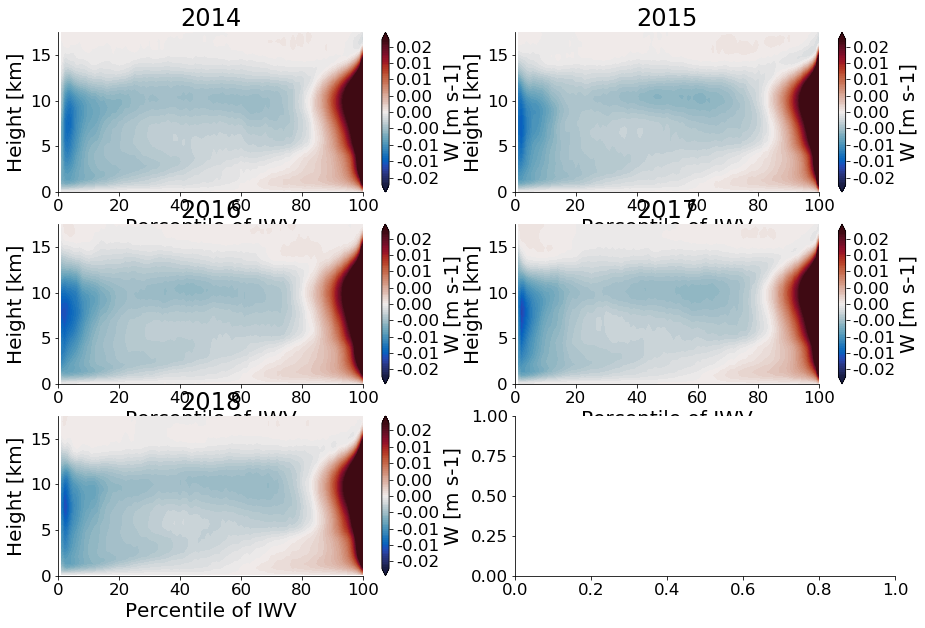

In [100]:
reload(plots)
fig, ax = plt.subplots(np.ceil(len(years) / 2).astype(int), 2, figsize=(15, 10))
tick_labels = np.arange(10, 81, 10)
ax = ax.ravel()

plt.rcParams.update({'font.size': 20})
x_lims = [0, 100]
y_lims = [0, 17.5]
x_label = 'Percentile of IWV'#axis_labels['IWV']
y_label = 'Height [km]'
contours = np.arange(-0.02, 0.020001, 0.0005)

lower_layer_bnd = 100
upper_layer_bnd = 12500

for i, year in enumerate(years):
    plots.moisture_space_contourf(fig, ax[i], perc_values, h * 1e-3, (ms_perc[year]['W'].mean.T), contours,\
                                  x_lims, y_lims, x_label, y_label, 'W [m s-1]',
                                  cm_orientation='vertical', cb_extend='both',\
                                  cmap='difference')
    ax[i].set_title(year)

DEBUG:locator: <matplotlib.ticker.FixedLocator object at 0x2af2a5c25c18>
DEBUG:Using fixed locator on colorbar
DEBUG:Setting pcolormesh


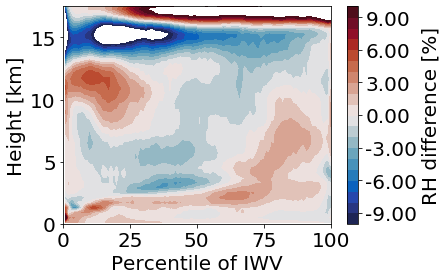

In [84]:
fig, ax = plt.subplots()
contours = np.arange(-10, 10.1, 1)
plots.moisture_space_contourf(fig, ax, perc_values, h * 1e-3, (ms_perc[2016]['RH'].mean.T - ms_perc[2014]['RH'].mean.T) * 1e2, contours,\
                                  x_lims, y_lims, x_label, y_label, 'RH difference [%]',
                                  cm_orientation='vertical', cb_extend='neither',\
                                  cmap='difference', vmin=contours[0], vmax=contours[-1])

DEBUG:locator: <matplotlib.ticker.FixedLocator object at 0x2af2a5b90ef0>
DEBUG:Using fixed locator on colorbar
DEBUG:Setting pcolormesh


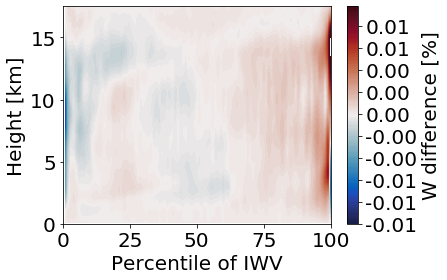

In [85]:
fig, ax = plt.subplots()
contours = np.arange(-0.01, 0.01, 0.0002)
plots.moisture_space_contourf(fig, ax, perc_values, h * 1e-3, (ms_perc[2016]['W'].mean.T - ms_perc[2014]['W'].mean.T), contours,\
                                  x_lims, y_lims, x_label, y_label, 'W difference [%]',
                                  cm_orientation='vertical', cb_extend='neither',\
                                  cmap='difference', vmin=contours[0], vmax=contours[-1])

In [44]:
np.max(ms_perc[year]['W'].mean.T)

0.09037548333643364